In [1]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchvision import transforms
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt

import torch.nn.functional as F

# -------------------------
# Dataset
# -------------------------
class StepwiseDeepVODataset(Dataset):
    def __init__(self, data_dir, img_size=(192, 640), transform=None):
        self.files = sorted(os.listdir(data_dir))
        self.data_dir = data_dir
        self.img_size = img_size
        self.transform = transform
        
    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        item = np.load(os.path.join(self.data_dir, self.files[idx]), allow_pickle=True)
        img1 = cv2.imread(item['img1'].item())
        img2 = cv2.imread(item['img2'].item())

        img1 = cv2.resize(img1, self.img_size).transpose(2, 0, 1) / 255.0
        img2 = cv2.resize(img2, self.img_size).transpose(2, 0, 1) / 255.0

        image_pair = np.concatenate([img1, img2], axis=0)
        pose = item['pose']

        return torch.tensor(image_pair, dtype=torch.float32), torch.tensor(pose, dtype=torch.float32)
    
# -------------------------
# Model
# -------------------------
class DeepVO(nn.Module):
    def __init__(self, input_size=(192, 640)):
        super(DeepVO, self).__init__()
        self.conv1 = nn.Conv2d(6, 64, kernel_size=7, stride=2, padding=3)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1)
        self.relu = nn.ReLU()

        # Dynamically compute the flattened size after conv layers
        dummy_input = torch.zeros(1, 6, *input_size)
        with torch.no_grad():
            x = self.relu(self.conv1(dummy_input))
            x = self.relu(self.conv2(x))
            x = self.relu(self.conv3(x))
            x = self.relu(self.conv4(x))
            conv_out_size = x.view(1, -1).shape[1]

        self.fc1 = nn.Linear(conv_out_size, 1000)
        self.fc2 = nn.Linear(1000, 6)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        return self.fc2(x)

# -------------------------
# Integrate and Plot
# -------------------------
def integrate_poses(y_output):
    y_output = y_output.detach().cpu().numpy()
    positions = [np.zeros(3)]
    curr_rot = R.identity()
    curr_pos = np.zeros(3)
    for i in range(y_output.shape[0]):
        dpos = y_output[i, :3]
        drot = y_output[i, 3:]
        global_dpos = curr_rot.apply(dpos)
        curr_pos += global_dpos
        positions.append(curr_pos.copy())
        dR = R.from_euler('xyz', drot, degrees=False)
        curr_rot = curr_rot * dR
    return np.array(positions)



# def integrate_poses(y_output):
#     if isinstance(y_output, torch.Tensor):
#         y_output = y_output.detach().cpu().numpy()

#     positions = [np.zeros(3)]
#     curr_rot = R.identity()
#     curr_pos = np.zeros(3)

#     for i in range(y_output.shape[0]):
#         dpos = y_output[i, :3]
#         drot = y_output[i, 3:]

#         # Sanitize drot to avoid NaN or inf
#         if not np.isfinite(drot).all():
#             print(f"Skipping invalid rotation at step {i}: {drot}")
#             continue

#         try:
#             dR = R.from_euler('xyz', drot, degrees=False)
#         except ValueError as e:
#             print(f"Invalid rotation at step {i}: {drot}, error: {e}")
#             continue

#         # Apply current rotation to delta position
#         global_dpos = curr_rot.apply(dpos)
#         curr_pos += global_dpos
#         positions.append(curr_pos.copy())

#         # Compose rotation
#         curr_rot = curr_rot * dR

#     return np.array(positions)

def plot_trajectory(positions):
    x, y, z = positions[:, 0], positions[:, 1], positions[:, 2]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(x, y, z)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

def geodesic_loss(pred_rot, true_rot):
    # Normalize quaternions
    pred_rot = F.normalize(pred_rot, p=2, dim=-1)
    true_rot = F.normalize(true_rot, p=2, dim=-1)

    # Compute the dot product of the predicted and true quaternions
    dot_prod = torch.sum(pred_rot * true_rot, dim=-1)
    
    # Clamping to avoid numerical issues (dot_prod could slightly exceed 1)
    dot_prod = torch.clamp(dot_prod, -1.0, 1.0)
    
    # Compute geodesic distance (angle) between quaternions
    angle = 2 * torch.acos(torch.abs(dot_prod))
    
    # Loss is the mean angular distance
    return torch.mean(angle)

def translation_loss(pred_translation, true_translation):
    return F.mse_loss(pred_translation, true_translation)

def combined_loss(pred, true):
    pred_translation, pred_rotation = pred[:, :3], pred[:, 3:]
    true_translation, true_rotation = true[:, :3], true[:, 3:]
    
    # Compute translation loss (Euclidean distance)
    translation_loss_val = translation_loss(pred_translation, true_translation)
    
    # Compute rotation loss (geodesic loss)
    rotation_loss_val = geodesic_loss(pred_rotation, true_rotation)
    
    # Total loss as a weighted sum
    total_loss = translation_loss_val + rotation_loss_val
    return total_loss

# -------------------------
# Training and Testing
# -------------------------
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(X)
        loss = criterion(pred, y)
        #loss = combined_loss(pred, y)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def test(model, dataloader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for X, _ in dataloader:
            X = X.to(device)
            pred = model(X)
            preds.append(pred.cpu())
    return torch.stack(preds)


device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# -------------------------
# Main
# -------------------------
import csv

loss_log_path = "checkpoints1_1/training_loss_l1.csv"

# Create the log file and write header if it doesn't exist
if not os.path.exists(loss_log_path):
    with open(loss_log_path, mode='w', newline='') as f:
        loss_writer = csv.writer(f)
        loss_writer.writerow(["Epoch", "Loss"])
        
train_dataset = StepwiseDeepVODataset("data/train/05")
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

model = DeepVO(input_size=(192, 640)).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
#criterion = nn.MSELoss()

class WeightedPoseLoss(nn.Module):
    def __init__(self, trans_weight=1.0, rot_weight=100.0):
        super().__init__()
        self.trans_weight = trans_weight
        self.rot_weight = rot_weight
        self.mse = nn.MSELoss()

    def forward(self, pred, target):
        pred_trans = pred[:, :3]
        pred_rot = pred[:, 3:]
        target_trans = target[:, :3]
        target_rot = target[:, 3:]

        trans_loss = self.mse(pred_trans, target_trans)
        rot_loss = self.mse(pred_rot, target_rot)

        return self.trans_weight * trans_loss + self.rot_weight * rot_loss

class PoseL1Loss(nn.Module):
    def __init__(self, trans_weight=1.0, rot_weight=100.0):
        super().__init__()
        self.trans_weight = trans_weight
        self.rot_weight = rot_weight
        self.l1 = nn.L1Loss()

    def forward(self, pred, target):
        pred_trans = pred[:, :3]
        pred_rot = pred[:, 3:]
        target_trans = target[:, :3]
        target_rot = target[:, 3:]

        trans_loss = self.l1(pred_trans, target_trans)
        rot_loss = self.l1(pred_rot, target_rot)

        return self.trans_weight * trans_loss + self.rot_weight * rot_loss


#criterion = PoseL1Loss(trans_weight=1.0, rot_weight=10.0)
criterion = WeightedPoseLoss(trans_weight=1.0, rot_weight=5.0)

# -------------------------------
# Load checkpoint if it exists
# -------------------------------
os.makedirs("checkpoints1_1", exist_ok=True)
ckpt_path = "checkpoints1_1/deepvo_checkpoint_weighted.pt"
start_epoch = 0
if os.path.exists(ckpt_path):
    checkpoint = torch.load(ckpt_path)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    start_epoch = checkpoint["epoch"] + 1
    print(f"Loaded checkpoint from epoch {start_epoch}")
else:
    print("Starting training from scratch")

for epoch in range(10):
    loss = train(model, train_loader, optimizer, criterion, device)
    print(f"Epoch {start_epoch+epoch}, Loss: {loss:.4f}")
    
    # Save loss to CSV
    with open(loss_log_path, mode='a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([start_epoch+epoch, loss])

    torch.save({
        "epoch": start_epoch+epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict()
    }, ckpt_path)
    #torch.save({
    #    "epoch": start_epoch+epoch,
    #    "model_state_dict": model.state_dict(),
    #    "optimizer_state_dict": optimizer.state_dict()
    #}, f"checkpoints1_1/deepvo_epoch{start_epoch+epoch}.pt")


Loaded checkpoint from epoch 2
Epoch 2, Loss: 0.0024
Epoch 3, Loss: 0.0015


In [5]:

model = DeepVO(input_size=(192, 640)).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

def test(model, dataloader, device):
    model.eval()
    preds = []
    gts = []
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            pred = model(X)
            preds.append(pred.cpu())
            gts.append(y.cpu())
    return torch.cat(preds), torch.cat(gts)

def plot_pred_vs_gt(pred_positions, gt_positions):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.plot(gt_positions[:, 0], gt_positions[:, 1], gt_positions[:, 2], label="Ground Truth", color='green')
    ax.plot(pred_positions[:, 0], pred_positions[:, 1], pred_positions[:, 2], label="Predicted", color='red')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    plt.show()


ckpt_path = "checkpoints1_1/deepvo_checkpoint_l1.pt"

if os.path.exists(ckpt_path):
    checkpoint = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    print(f"Loaded model from epoch {checkpoint['epoch']+1}")
else:
    raise FileNotFoundError("Model not found!")

model.eval()

Loaded model from epoch 12


DeepVO(
  (conv1): Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv3): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu): ReLU()
  (fc1): Linear(in_features=122880, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=6, bias=True)
)

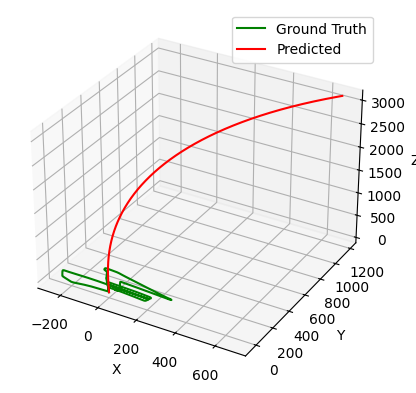

: 

In [ ]:
test_dataset = StepwiseDeepVODataset("data/train/05")
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

pred_outputs, gt_outputs = test(model, test_loader, device)

pred_positions = integrate_poses(pred_outputs)
gt_positions = integrate_poses(gt_outputs)

plot_pred_vs_gt(pred_positions, gt_positions)

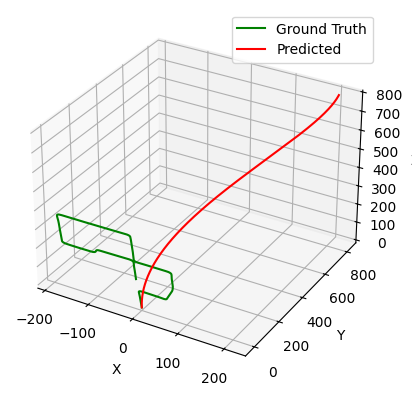

In [5]:

test_dataset = StepwiseDeepVODataset("data/train/00_short")
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

pred_outputs, gt_outputs = test(model, test_loader, device)

pred_positions = integrate_poses(pred_outputs)
gt_positions = integrate_poses(gt_outputs)

plot_pred_vs_gt(pred_positions, gt_positions)

Create npz files for training

In [6]:
import os
import cv2
import numpy as np
from tqdm import tqdm

def load_poses(pose_file):
    poses = []
    with open(pose_file, 'r') as f:
        for line in f:
            T = np.array(list(map(float, line.strip().split()))).reshape(3, 4)
            pose = np.eye(4)
            pose[:3, :] = T
            poses.append(pose)
    return poses

def compute_rel_poses(poses):
    rel_poses = []
    for i in range(1, len(poses)):
        rel = np.linalg.inv(poses[i-1]) @ poses[i]
        trans = rel[:3, 3]
        rot = rel[:3, :3]
        rpy = cv2.Rodrigues(rot)[0].flatten()
        rel_poses.append(np.hstack([trans, rpy]))
    return np.array(rel_poses)

def preprocess_lightweight(seq, save_dir, img_size=(192, 640)):
    os.makedirs(save_dir, exist_ok=True)
    img_dir = f"/home/ros_ws/noetic/data/kitti/sequences/{seq}/image_0"
    pose_file = f"/home/ros_ws/noetic/data/kitti/data_odometry_poses/{seq}.txt"

    images = sorted(os.listdir(img_dir))
    poses = load_poses(pose_file)
    rel_poses = compute_rel_poses(poses)

    for i in tqdm(range(len(rel_poses))):
        data = {
            'img1': os.path.join(img_dir, images[i]),
            'img2': os.path.join(img_dir, images[i+1]),
            'pose': rel_poses[i]
        }
        np.savez(os.path.join(save_dir, f"{i:06d}.npz"), **data)

# Example usage
preprocess_lightweight("07", "data/train/07", img_size=(192, 640))


100%|██████████| 1100/1100 [00:00<00:00, 8921.10it/s]


In [1]:
import cv2

im = cv2.imread('/home/ros_ws/noetic/data/kitti/sequences/05/image_0/000000.png')

print(type(im))
print(im.shape)
print(type(im.shape))

<class 'numpy.ndarray'>
(370, 1226, 3)
<class 'tuple'>
